## 0.0 IMPORTS

In [1]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import kurtosis, skew, norm
import math
import statistics
from scipy.stats import chi2
import dask.dataframe as dd

pd.set_option('float_format', '{:.3f}'.format)

## 0.1 - HELPER FUNCTION (FUNÇÕES AUXILIARES)

In [22]:
def show_descriptive_statistical(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

## 0.2 - PATH DEFINITION

In [3]:
HOME_PATH = '/home/valmir/Documentos/deteccao_fraude/'
RAW_DATA_PATH = 'data/raw/'
INTERIM_DATA_PATH = 'data/intermediario/'
FIGURE_PATH = 'reports/figures/'

## 0.3 - LOAD DATA

In [4]:
"""%%time
dtype = {'step':'category',
         'type':'category',
         'amount':'float16',
         'nameOrig':'category',
         'oldbalanceOrg':'float16',
         'newbalanceOrig':'float16',
         'oldbalanceDest':'float16',
         'newbalanceDest':'float16',
         'isFraud': 'int16',
         'isFlaggedFraud':'int32'}
"""
base_fraude_raw = pd.read_csv(HOME_PATH+RAW_DATA_PATH+'fraud_detection_dataset.csv')



In [5]:
base_fraude_raw.memory_usage().sum() / 1024**2

533.9724426269531

In [6]:
base_fraude_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## 1.0 - DATA DESCRIPITION

In [7]:
#base_fraude_raw1 = base_fraude_raw.copy()
#base_fraude_raw1.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw1.csv')
base_fraude_raw1 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw1.csv')


In [8]:
base_fraude_raw1.memory_usage().sum() / 1024**2

582.515380859375

## 1.1 - DATA FIELD'S

Os dados contidos nesta base de dados são simulados e compreendem 30 dias. Estas transações podem ser de diferentes tipo e foram executadas via mobile devices. As features contidas nesta base de dados são:

 * `step` - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744(31
  dias);

 * `type`: Tipo: tipo de transação(depósito, saque, débito, pagamento e transferencia);

 * `amount`: Quantia: total que foi transacionado;

 * `nameOring`: ClienteOrigem: cliente que iniciou atransação;

 * `oldbalanceOrg`: SaldoInicialOrigem: saldo da conta de origem antes da transação;

 * `newbalanceOrig`: SaldoFinalOrigem: saldo da conta de origem depois da transação;

 * `nameDest`: ClienteDestino: cliente de destino da transação;

 * `oldbalandeDestino`: SaldoInicialDestino: saldo da conta destino antes da transação;

 * _`newbalanceDest`_: SaldoFinalDestino: saldo da conta destino depois da transação;

 * `isFraud`: Fraude: flag que define se a transação é fraudolenta ou não. Nesta simulação de fraude é a assumir se 'a conta do usuario foi   esvaziada e transferindo o dinherio para outra conta e depois sacado
 
 * `IssFlaggedFraud`: SinalizadaFraude: automaticamente categorizada como fraude pelo banco por fraude por tentar trasnferir mais de 200 mil em uma única conta


## 1.2 - RENAME COLUMNS

In [9]:
base_fraude_raw1.rename(columns={'step':'Passos', 'type':'Tipo', 'amount': 'Quantia',
                                'nameOrig':'ClienteOrigem', 'oldbalanceOrg': 'SaldoInicalOrig',
                                'newbalanceOrig':'SaldoFinalOrig', 'nameDest':'ClienteDest',
                                'oldbalanceDest':'SaldoInicialDest', 'newbalanceDest':'SaldoFinalDest',
                                'isFraud':'Fraude', 'isFlaggedFraud':'SinalizadaFraude'}, inplace=True)


## 1.3 - DATA DIMENSIONS

In [23]:
num_linhas, num_colunas = base_fraude_raw1.shape

print('Numero de linhas', num_linhas)
print('Numero de colunas', num_colunas)

Numero de linhas 6362620
Numero de colunas 12


## 1.4 - DATA TYPES

In [24]:
#base_fraude_categoria = base_fraude_raw1[['Tipo','ClienteDest', 'ClienteOrigem']].astype('category')
base_fraude_raw1.dtypes

Unnamed: 0            int64
Passos                int64
Tipo                 object
Quantia             float64
ClienteOrigem        object
SaldoInicalOrig     float64
SaldoFinalOrig      float64
ClienteDest          object
SaldoInicialDest    float64
SaldoFinalDest      float64
Fraude                int64
SinalizadaFraude      int64
dtype: object

## 1.5 CHANGE TYPE

#### Não houve nenhuma mudança nos tipos de variaveis nessa etapa, pois todas as features se encontravam com seus tipos bem definidos

## 1.6 - CHECK N.A.

### Não foi encontrado nenhum valor nulo nesse Dataset

In [25]:
base_fraude_raw1.isnull().sum()

Unnamed: 0          0
Passos              0
Tipo                0
Quantia             0
ClienteOrigem       0
SaldoInicalOrig     0
SaldoFinalOrig      0
ClienteDest         0
SaldoInicialDest    0
SaldoFinalDest      0
Fraude              0
SinalizadaFraude    0
dtype: int64

In [30]:
base_fraude_raw1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   Passos            int64  
 2   Tipo              object 
 3   Quantia           float64
 4   ClienteOrigem     object 
 5   SaldoInicalOrig   float64
 6   SaldoFinalOrig    float64
 7   ClienteDest       object 
 8   SaldoInicialDest  float64
 9   SaldoFinalDest    float64
 10  Fraude            int64  
 11  SinalizadaFraude  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 582.5+ MB


## 1.7 - FILL OUT N.A.

### Não havendo nenhum valor faltante nesse Dataset, não foi nescessario nenhum metodo de preenchimento ou exclusão dos mesmos

## 1.8 DISCRIPTIVE STATISTICAL

In [26]:
num_attributes = base_fraude_raw1.select_dtypes(include=['int64', 'float64'])
cat_attributes = base_fraude_raw1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])



Medidas de tendencia central - 
 - Media
 - Mediana
 

Medidas de Dispersão

- Skewness
- Kurtosis
- Desvio Padrão
- Range (alcance)
- Min
- Max

### 1.8.1 - NUMERIC ESTATISTIC

In [27]:
m = show_descriptive_statistical(num_attributes)
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Unnamed: 0,0.000,6362619.000,6362619.000,3181309.500,3181309.500,1836730.185,0.000,-1.200
1,Passos,1.000,743.000,742.000,243.397,239.000,142.332,0.375,0.329
2,Quantia,0.000,92445516.640,92445516.640,179861.904,74871.940,603858.184,30.994,1797.957
3,SaldoInicalOrig,0.000,59585040.370,59585040.370,833883.104,14208.000,2888242.446,5.249,32.965
4,SaldoFinalOrig,0.000,49585040.370,49585040.370,855113.669,0.000,2924048.273,5.177,32.067
5,SaldoInicialDest,0.000,356015889.350,356015889.350,1100701.667,132705.665,3399179.846,19.922,948.674
6,SaldoFinalDest,0.000,356179278.920,356179278.920,1224996.398,214661.440,3674128.653,19.352,862.157
7,Fraude,0.000,1.000,1.000,0.001,0.000,0.036,27.780,769.703
8,SinalizadaFraude,0.000,1.000,1.000,0.000,0.000,0.002,630.604,397659.062


In [21]:
print(m)

type: name 'm' is not defined

In [26]:
base_fraude_raw1.tail()

,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude
6362615,6362615,743,CASH_OUT,339682.130,C786484425,339682.130,0.000,C776919290,0.000,339682.130,1,0
6362616,6362616,743,TRANSFER,6311409.280,C1529008245,6311409.280,0.000,C1881841831,0.000,0.000,1,0
6362617,6362617,743,CASH_OUT,6311409.280,C1162922333,6311409.280,0.000,C1365125890,68488.840,6379898.110,1,0
6362618,6362618,743,TRANSFER,850002.520,C1685995037,850002.520,0.000,C2080388513,0.000,0.000,1,0
6362619,6362619,743,CASH_OUT,850002.520,C1280323807,850002.520,0.000,C873221189,6510099.110,7360101.630,1,0


### 1.8.2 - CATEGORICAL ATRIBUTES



In [14]:

cat_attributes.apply(lambda x: x.unique().shape[0])

Unnamed: 0          6362620
Passos                  743
Tipo                      5
Quantia             5316900
ClienteOrigem       6353307
SaldoInicalOrig     1845844
SaldoFinalOrig      2682586
ClienteDest         2722362
SaldoInicialDest    3614697
SaldoFinalDest      3555499
Fraude                    2
SinalizadaFraude          2
dtype: int64

## 2.0 - FEATURE ENGINEERING- PARTE I

In [15]:
#base_fraude_raw2 = base_fraude_raw1.copy()
#base_fraude_raw2.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw2.csv')
base_fraude_raw2 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw2.csv')

In [16]:
base_fraude_raw2.memory_usage().sum() / 1024**2

631.0583190917969

## 2.1 - MAPA MENTAL DE HIPOTESE

![MapaMental de Hipotese]
(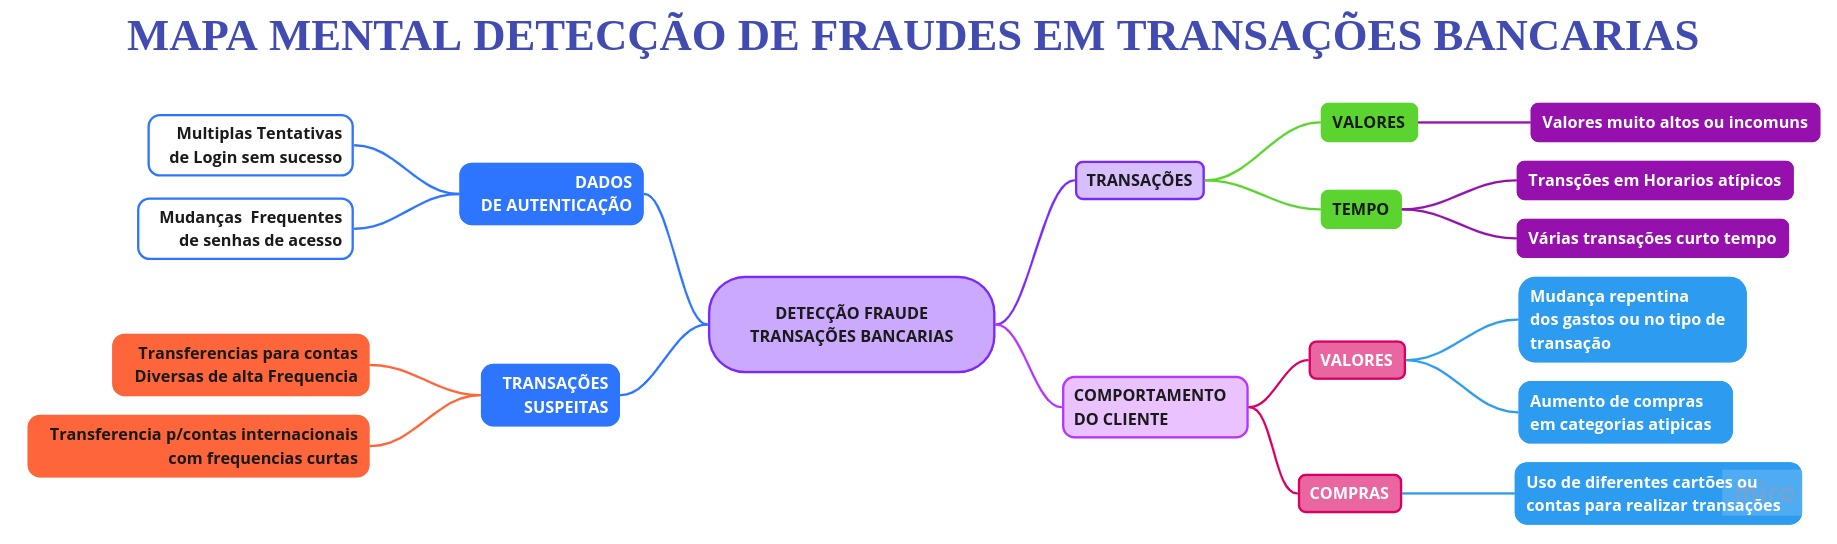)


## 2.2 - CRIAÇÃO DAS HIPOTESE

### TRANSAÇÕES 
 * QUANDO OS VALORES DAS TRANSAÇÕES FOREM MUITO ALTOS OU INCOMUNS EM RELAÇÃO AOS PADRÕES COMUNS DO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM HORÁRIOS ATÍPICOS AOS PADRÕES COMUNS REALIZADAS PELO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM MOMENTOS DE TEMPO MUITO CURTOS, SERAM CLASSIFICADOS COMO FRAUDES; 

 ### COMPORTAMENTO DO CLIENTE
 * QUANDO HOUVER MUDANÇAS REPENTINAS DOS VALORES DOS GASTOS E/OU DA FORMA DE TRANSAÇÃO TÍPICA DO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES MUDAREM REPENTINAMENTE DO TIPO DA CATEGORIA QUE O CLIENTE EVENTUALMENTE REALIZA, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO HOUVER A TROCA DESORDENADA DO CARTÃO QUE O CLIENTE UTILIZA EVENTUALMENTE EM SUAS TRANSAÇÕES, SERAM CLASSIFICADOS COMO FRAUDES;

 ### DADOS DE AUTENTICAÇÃO
 * QUANDO HOUVER MULTIPLAS TENTATIVAS ERRADAS, SOLICITAÇÃO DE NOVA SENHA ANTES DO CLIENTE CONSEGUIR LOGAR, SERAM CLASSIFICADOS COMO FRAUDES;
 
 ### TRANSAÇÕES SUSPEITAS
 * QUANDO HOUVER TRANSFERENCIAS PARA CONTAS DIVERSAS DAS HABITUAIS REALIZADAS PELO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;
 
 * QUANDO HOUVER TRANSFERENCIAS PARA CONTAS INTERNACIONAIS COM FREQUENCIAS DE CURTO ESPAÇO DE TEMPO, SERAM CLASSIFICADOS COMO FRAUDES;


## 2.3 - LISTA FINAL DE HIPOTESE

### TRANSAÇÕES 
 * QUANDO OS VALORES DAS TRANSAÇÕES FOREM MAIORES QEU 200.000,00, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM MOMENTOS DE TEMPO MUITO CURTOS, SERAM CLASSIFICADOS COMO FRAUDES; 

 ### COMPORTAMENTO DO CLIENTE
 * QUANDO HOUVER MUDANÇAS REPENTINAS DOS VALORES DOS GASTOS E/OU DA FORMA DE TRANSAÇÃO TÍPICA DO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 ### TRANSAÇÕES SUSPEITAS
 * QUANDO HOUVER TRANSFERENCIAS PARA CONTAS DIVERSAS DAS HABITUAIS REALIZADAS PELO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;
 
 

## 2.4 - FEATURE ENGINEERING - PARTE 1

`QUANTAS TRANSAÇÕES REALIZOU CADA CLIENTE? ` 
Criei a coluna chamada FreqCliente que nada mais é que a frequencia de transações por cliente

In [17]:
base_fraude_raw2['FreqCliente'] = base_fraude_raw2.groupby('ClienteOrigem')['ClienteOrigem'].transform('count')


In [33]:
base_fraude_raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0.1      int64  
 1   Unnamed: 0        int64  
 2   Passos            int64  
 3   Tipo              object 
 4   Quantia           float64
 5   ClienteOrigem     object 
 6   SaldoInicalOrig   float64
 7   SaldoFinalOrig    float64
 8   ClienteDest       object 
 9   SaldoInicialDest  float64
 10  SaldoFinalDest    float64
 11  Fraude            int64  
 12  SinalizadaFraude  int64  
 13  FreqCliente       int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 679.6+ MB


## 3.0 - FILTRAGEM DE VARIAVEIS 

In [28]:
#base_fraude_raw3 = base_fraude_raw2.copy()
#base_fraude_raw3.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw3.csv')
base_fraude_raw3 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw3.csv')

In [27]:
base_fraude_raw3.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,FreqCliente
0,0,0,0,1,PAYMENT,9839.640,C1231006815,inf,inf,M1979787155,0.000,0.000,0,0,1
1,1,1,1,1,PAYMENT,1864.280,C1666544295,21248.000,19392.000,M2044282225,0.000,0.000,0,0,1
2,2,2,2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,1
3,3,3,3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21184.000,0.000,1,0,1
4,4,4,4,1,PAYMENT,11668.140,C2048537720,41568.000,29888.000,M1230701703,0.000,0.000,0,0,1


## 3.1 - FILTRAGEM DE LINHAS 
Devido termos poucas colunas a quantidade de linhas farão toda a diferença, visto que não possuimos valores nulos e o valores `0` em algumas 

linhas são afirmações de `NÃO TRANSAÇÃO`, impactando assim, diretamente nos resultados finais.

## 3.2 - FILTRAGEM DE COLUNAS - SELEÇÃO DAS COLUNAS

In [29]:
del base_fraude_raw3['Unnamed: 0']
del base_fraude_raw3['Unnamed: 0.1']
del base_fraude_raw3['Unnamed: 0.2']

In [39]:
base_fraude_raw3.memory_usage().sum() / 1024**2

582.515380859375

## 4.0 - ANALISE E VISUALIZAÇÕES

In [ ]:
dtype = {'Passos':'category',
         'Tipo':'category',
         'Quant':'float16',
         'ClienteOrigem':'category',
         'SaldoInicalOrig':'float16',
         'SaldoFinalOrig':'float16',
         'SaldoInicialDest':'float16',
         'SaldoFinalDest':'float16',
         'Fraude': 'int16',
         'SinalizadaFraude':'int16',
         'FreqCliente':'int16'}
"""base_fraude_raw4 = base_fraude_raw3()"""
#base_fraude_raw4.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')
base_fraude_raw4 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv', dtype=dtype)
#base_fraude_raw4_dd = dd.from_pandas(base_fraude_raw3, npartitions=4)

In [41]:
del base_fraude_raw4['Unnamed: 0']

In [38]:
base_fraude_raw4.memory_usage().sum() / 1024**2


450.5477294921875

In [21]:
base_reduz = 'base_reduz.csv'
caminho_salvar = '/home/valmir/Documentos/deteccao_fraude/data/raw' + base_reduz
base_fraude_raw4.to_csv(caminho_salvar, index=False)

In [40]:
base_fraude_raw4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Unnamed: 0        int64   
 1   Passos            category
 2   Tipo              category
 3   Quantia           float64 
 4   ClienteOrigem     category
 5   SaldoInicalOrig   float16 
 6   SaldoFinalOrig    float16 
 7   ClienteDest       object  
 8   SaldoInicialDest  float16 
 9   SaldoFinalDest    float16 
 10  Fraude            int16   
 11  SinalizadaFraude  int16   
 12  FreqCliente       int16   
dtypes: category(3), float16(4), float64(1), int16(3), int64(1), object(1)
memory usage: 450.5+ MB


In [8]:
base_fraude_raw4_2.memory_usage().sum() / 1024**2

450.5477294921875

In [16]:
#num_attributes = base_fraude_raw4.select_dtypes(include=['int64', 'float64'])
#cat_attributes = base_fraude_raw4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
num_attributes.head(), cat_attributes.head()


(   Unnamed: 0  Passos   Quantia  SaldoInicalOrig  SaldoFinalOrig  \
 0           0       1  9839.640       170136.000      160296.360   
 1           1       1  1864.280        21249.000       19384.720   
 2           2       1   181.000          181.000           0.000   
 3           3       1   181.000          181.000           0.000   
 4           4       1 11668.140        41554.000       29885.860   
 
    SaldoInicialDest  SaldoFinalDest  Fraude  SinalizadaFraude  
 0             0.000           0.000       0                 0  
 1             0.000           0.000       0                 0  
 2             0.000           0.000       1                 0  
 3         21182.000           0.000       1                 0  
 4             0.000           0.000       0                 0  ,
        Tipo ClienteOrigem  ClienteDest
 0   PAYMENT   C1231006815  M1979787155
 1   PAYMENT   C1666544295  M2044282225
 2  TRANSFER   C1305486145   C553264065
 3  CASH_OUT    C840083671    C38

In [18]:
base_fraude_raw4_dd = base_fraude_raw4_dd.persist()

In [19]:
base_fraude_raw4 = base_fraude_raw4_dd.compute()

In [20]:
base_fraude_raw4.head()

,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,FreqCliente
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,1
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,1
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,1
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,1
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,1


### 4.1 - Análise e Visualização Univariada

In [17]:
del base_fraude_raw4['Unnamed: 0']
base_fraude_raw4.head()

,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,FreqCliente
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,1
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,1
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,1
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,1
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,1


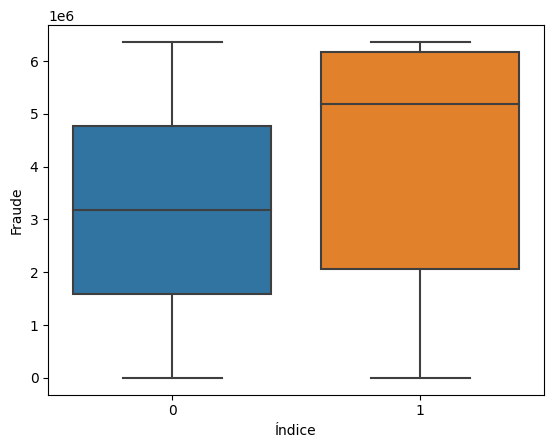

In [32]:
sns.boxplot(data=base_fraude_raw4, x='Fraude', y=base_fraude_raw4.index)
plt.xlabel('Índice')
plt.ylabel('Fraude')
plt.show()

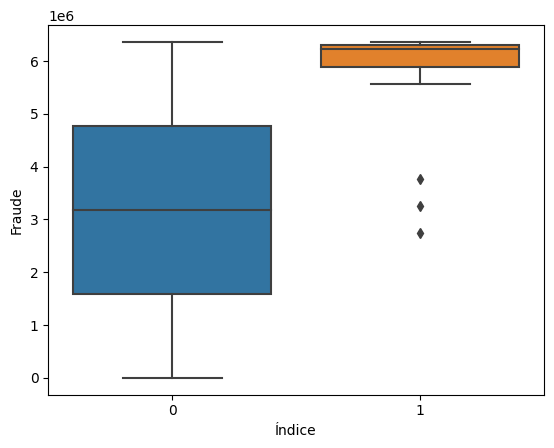

In [33]:
sns.boxplot(data=base_fraude_raw4, x='SinalizadaFraude', y=base_fraude_raw4.index)
plt.xlabel('Índice')
plt.ylabel('Fraude')
plt.show()

### 4.2 - Análise e Visualização Bivariada

In [20]:
num_attributes.columns, cat_attributes.columns

(Index(['Unnamed: 0', 'Passos', 'Quantia', 'SaldoInicalOrig', 'SaldoFinalOrig',
        'SaldoInicialDest', 'SaldoFinalDest', 'Fraude', 'SinalizadaFraude'],
       dtype='object'),
 Index(['Tipo', 'ClienteOrigem', 'ClienteDest'], dtype='object'))

In [1]:
sns.countplot(data=base_fraude_raw4_2,x='Quantia')

NameError: name 'sns' is not defined

### 4.3 - Análise e Visualização Multivariada